In [1]:
%matplotlib inline
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt
import math

Mean of readings is 9.997


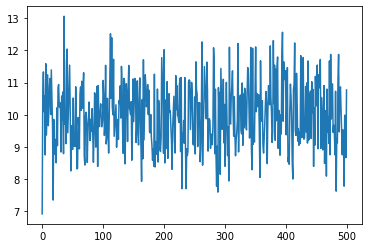

In [2]:
xs = range(500)
ys = randn(500)*1 +10
plt.plot(xs,ys)
print('Mean of readings is {:.3f}'.format(np.mean(ys)))

In [3]:
from collections import namedtuple
gaussian = namedtuple('Gaussian', ['mean','var'])
gaussian.__repr__ = lambda s: '𝒩(μ={:.3f}, 𝜎²={:.3f})'.format(s[0], s[1])
g1 = gaussian(3.4, 10.1)
g2 = gaussian(mean=4.5, var=0.2**2)
print(g1)
print(g2)


𝒩(μ=3.400, 𝜎²=10.100)
𝒩(μ=4.500, 𝜎²=0.040)


### 1. Prediction
The position is uncertain and the amount moved is also uncertain - both in a gaussian manner. So the two uncertainties are added since they are both in the same unit.

prediction = current position gaussian + movement gaussian

In [4]:
def predict(pos,movement):
    return gaussian(pos.mean + movement.mean, pos.var + movement.var)

**Example) What is the prior if the intitial position is the Gaussian N(10,0.22) and the movement is the Gaussian N(15,0.72)?**

In [5]:
pos = gaussian(10., .2**2)
move = gaussian(15., .7**2)
predict(pos, move)

𝒩(μ=25.000, 𝜎²=0.530)

### 2. Updates
Baye's rule state: posterior = normalized ( likelihood * prior )

**likelihood:** the probability of the measurement given the current state
**prior:** current state estimate in the form of a gaussian


In [6]:
def gaussian_multiply(g1, g2):
    mean = (g1.var * g2.mean + g2.var * g1.mean)/ (g1.var + g2.var)
    variance = (g1.var * g2.var) / (g1.var + g2.var)
    return gaussian(mean, variance)
def update(likelihood, prior):
    posterior = gaussian_multiply( likelihood, prior )
    return posterior

## Trying it out

Dog tracking simulation

### The simulator

In [11]:
def compute_dog_data(x, vel, z_var, process_var, count=1, dt=1.):
    "returns track, measurements 1D ndarrays"
    z_std = math.sqrt(z_var) 
    p_std = math.sqrt(process_var)
    xs, zs = [], []
    for _ in range(count):
        v = vel + (randn() * p_std)
        x += v*dt        
        xs.append(x)
        zs.append(x + randn() * z_std)        
    return np.array(xs), np.array(zs)

## The measurement 

In [14]:
np.random.seed(10)

process_var = 1 # variance in the dog's movement
sensor_var = 2 # variance in the sensor

x=0
velocity=1
dt = 1
# create list of measurements
xs, zs = compute_dog_data(x=x,vel=velocity,z_var=sensor_var, process_var=process_var, count=10, dt=dt)
# zs = [dog.move_and_sense() for _ in range(10)]
print(zs)

[3.34314373 1.77432966 2.38916742 4.82654457 5.43040322 8.81170316
 8.59948487 9.0034355  8.42842605 9.19477593]


## Kalman filter implementation

In [16]:
x = gaussian(0, 20**2) # dog's position, N(0, 20**2)
process_model = gaussian(velocity*dt,process_var) # displacement to add to x

for z in zs:
    prior = predict(x, process_model)
    print('prior.mean:{:10.3f}    prior.var:{:10.3f}'.format(x.mean, x.var))    
    likelihood = gaussian(z, sensor_var)
    x = update(likelihood, prior)
    print('measurement: {:10.3f}'.format(z))
    print('posterior.mean:{:10.3f}    posterior.var:{:10.3f}'.format(x.mean, x.var)) 
    print('\n')


print('final estimate:         {:10.3f}'.format(x.mean))
print('actual final position:  {:10.3f}'.format(xs[-1]))

prior.mean:     0.000    prior.var:   400.000
measurement:      3.343
posterior.mean:     3.332    posterior.var:     1.990


prior.mean:     3.332    prior.var:     1.990
measurement:      1.774
posterior.mean:     2.799    posterior.var:     1.198


prior.mean:     2.799    prior.var:     1.198
measurement:      2.389
posterior.mean:     3.061    posterior.var:     1.047


prior.mean:     3.061    prior.var:     1.047
measurement:      4.827
posterior.mean:     4.448    posterior.var:     1.012


prior.mean:     4.448    prior.var:     1.012
measurement:      5.430
posterior.mean:     5.439    posterior.var:     1.003


prior.mean:     5.439    prior.var:     1.003
measurement:      8.812
posterior.mean:     7.626    posterior.var:     1.001


prior.mean:     7.626    prior.var:     1.001
measurement:      8.599
posterior.mean:     8.613    posterior.var:     1.000


prior.mean:     8.613    prior.var:     1.000
measurement:      9.003
posterior.mean:     9.308    posterior.var:     

## ABOVE CODE SIMPLIFIED is shown below

In [17]:
pos = 0  #initial estimate
var = 1

for z in zs:
    # predict
    dx = velocity*dt
    pos = pos + dx
    var = var + process_var
    print('prediction {:10.3f}'.format(pos))
    print('measurement {:10.3f}'.format(z))
    # update
    pos  = (var*z + sensor_var*pos) / (var + sensor_var)
    var = (var * sensor_var) / (var + sensor_var)
    print('posterior {:10.3f}'.format(pos))
    print('-')
    

prediction      1.000
measurement      3.343
posterior      2.172
-
prediction      3.172
measurement      1.774
posterior      2.473
-
prediction      3.473
measurement      2.389
posterior      2.931
-
prediction      3.931
measurement      4.827
posterior      4.379
-
prediction      5.379
measurement      5.430
posterior      5.405
-
prediction      6.405
measurement      8.812
posterior      7.608
-
prediction      8.608
measurement      8.599
posterior      8.604
-
prediction      9.604
measurement      9.003
posterior      9.304
-
prediction     10.304
measurement      8.428
posterior      9.366
-
prediction     10.366
measurement      9.195
posterior      9.780
-


# Kalman Gain 이라는 방식으로 새롭게 전개한다면? 


In [18]:
def update(prior, measurement):
    x, P = prior        # mean and variance of prior
    z, R = measurement  # mean and variance of measurement
    
    y = z - x        # residual
    K = P / (P + R)  # Kalman gain

    x = x + K*y      # posterior
    P = (1 - K) * P  # posterior variance
    return gaussian(x, P)

def predict(posterior, movement):
    x, P = posterior # mean and variance of posterior
    dx, Q = movement # mean and variance of movement
    x = x + dx
    P = P + Q
    return gaussian(x, P)

In [20]:
x = gaussian(0, 20**2) # dog's position, N(0, 20**2)
for z in zs:
    prior = predict(x, process_model)
    print('prior.mean:{:10.3f}    prior.var:{:10.3f}'.format(x.mean, x.var))    
    likelihood = gaussian(z, sensor_var)
    x = update(likelihood, prior)
    print('measurement: {:10.3f}'.format(z))
    print('posterior.mean:{:10.3f}    posterior.var:{:10.3f}'.format(x.mean, x.var)) 
    print('\n')


print('final estimate:         {:10.3f}'.format(x.mean))
print('actual final position:  {:10.3f}'.format(xs[-1]))

prior.mean:     0.000    prior.var:   400.000
measurement:      3.343
posterior.mean:     3.332    posterior.var:     1.990


prior.mean:     3.332    prior.var:     1.990
measurement:      1.774
posterior.mean:     2.799    posterior.var:     1.198


prior.mean:     2.799    prior.var:     1.198
measurement:      2.389
posterior.mean:     3.061    posterior.var:     1.047


prior.mean:     3.061    prior.var:     1.047
measurement:      4.827
posterior.mean:     4.448    posterior.var:     1.012


prior.mean:     4.448    prior.var:     1.012
measurement:      5.430
posterior.mean:     5.439    posterior.var:     1.003


prior.mean:     5.439    prior.var:     1.003
measurement:      8.812
posterior.mean:     7.626    posterior.var:     1.001


prior.mean:     7.626    prior.var:     1.001
measurement:      8.599
posterior.mean:     8.613    posterior.var:     1.000


prior.mean:     8.613    prior.var:     1.000
measurement:      9.003
posterior.mean:     9.308    posterior.var:     